In [1]:
import numpy as np 
from scipy.stats.qmc import Sobol

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100

## Exercise 2 {-}

### (a) {-}

We begin by defining the integrand $f$.

In [2]:
def f(y):    
    y = np.atleast_2d(y)
    N,s = y.shape
    
    res = np.empty((N,))
    res[:] = np.power(2 + 1/(2.*s), s)
    
    exponent = 1 + 1/(2.*s)
    
    for yj in y.T:
        res[:] *= np.power(yj, exponent)
        
    return res

Next, we can define a general purpose qmc function, which is straightforward since we defined `f` above in a vectorized way. 

In [26]:
def qmc(f, points, with_var=False):
    return np.mean(f(points))

We also define a function to plot the results.

In [36]:
def plot_results(dims, Ns, errors, plot_factor=1, rate=1, error_label="QMC Error"):
    cols = 2
    rows = len(dims) // cols
    rows += len(dims) % cols
    position = range(1, len(dims) + 1)

    fig, axes = plt.subplots(rows,cols,sharey=True,figsize=(8,8))

    for i,ax in enumerate(axes.flat):
        err = errors[i,:]

        ax.loglog(Ns,err,label=error_label)
        ax.title.set_text(f"Dimension $s = ${dims[i]}")

        # Plot convergence rate
        x0 = Ns[0]
        x1 = Ns[-1]
        y = lambda x : plot_factor*err[0]*x**-float(rate)
        y0 = y(x0)
        y1 = y(x1)

        ax.loglog([x0,x1], [y0,y1], '--', color='gray', linewidth=1, label=f"$\mathcal{{O}}(N^{{-{rate}}})$")
        ax.legend()

    fig.tight_layout()
    plt.show();

#### (i) Lattice rule {-}

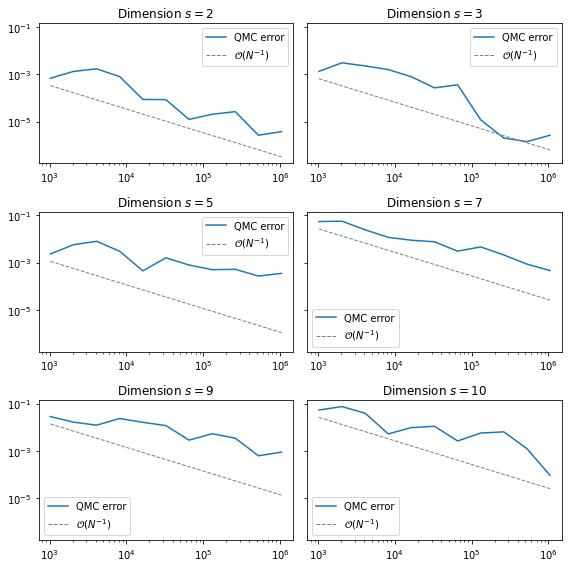

In [5]:
dims = [2,3,5,7,9,10]
Ns   = np.power(2,range(10,20+1))

errors = np.empty((len(dims), len(Ns)))

z_full = np.fromfile("generatingVectorQMC.txt", sep=" ").reshape((-1,2))[:,1]
for i,s in enumerate(dims):
    z = z_full[:s]
    for j,N in enumerate(Ns):        
        points = np.array([k/N*z % 1. for k in range(N+1)])
                        
        errors[i,j] = abs(1 - qmc(f,points))
        
plot_results(dims, Ns, errors, plot_factor=500)

It seems that convergence is almost dimension independent with rate $\mathcal{O}(N^{-1})$.

#### (ii) Sobol points {-}

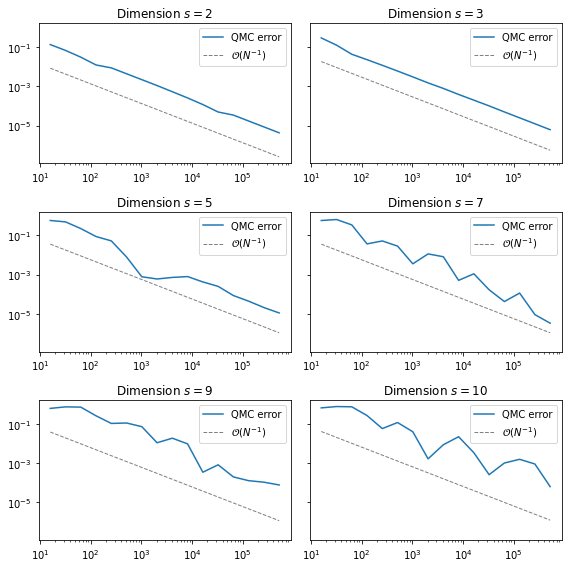

In [27]:
dims = [2,3,5,7,9,10]
ms   = range(4,20) # number of Sobol points
Ns   = np.power(2,ms)

errors = np.empty((len(dims), len(ms)))

for i,s in enumerate(dims):
    for j,m in enumerate(ms):
        points = Sobol(s,scramble=False).random_base2(m)              
        errors[i,j] = abs(1 - qmc(f,points))
              
plot_results(dims, Ns, errors)

Here, we observe better dimension independence; the convergence rate is again $\mathcal{O}(N^{-1})$. 

Both examples above are clearly better than the tensor rules from the first exercise sheet where we observed a rate of $\mathcal{O}(N^{-2/s})$ when using the product trapezoidal rule (which is a better rate for $s = 1$ but worse for $s \ge 3$.

### (b) {-}

Let us first define the integrand $g$.

In [14]:
def g(y):
    y = np.atleast_2d(y)
    _,s = y.shape
    
    return 1 / ( 1 + np.sum((y - 0.5)/(np.arange(1,s+1)**2), axis=1))

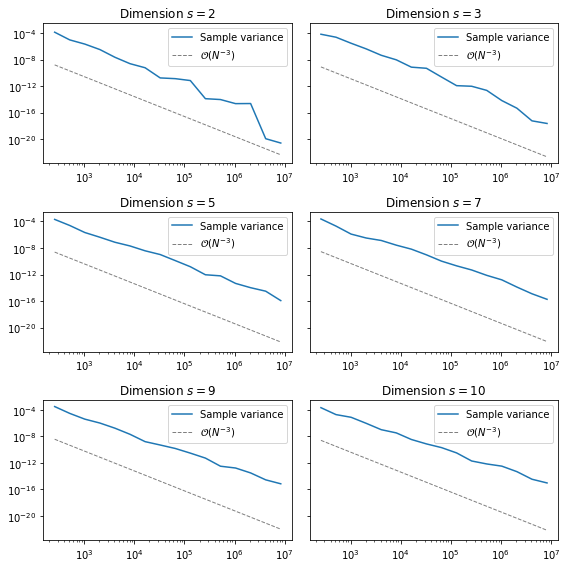

In [43]:
dims = [2,3,5,7,9,10]
ms   = range(4,20) # number of Sobol points
R    = 16
Ns   = R*np.power(2,ms)

errors = np.empty((len(dims), len(ms)))

for i,s in enumerate(dims):
    for j,m in enumerate(ms):
        qmc_res = np.empty((R,))
        for r in range(R):
            points = Sobol(s,scramble=True).random_base2(m)
            qmc_res[r] = qmc(g, points)
        errors[i,j] = np.var(qmc_res)
              
plot_results(dims, Ns, errors, rate=3, error_label="Sample variance", plot_factor=200)

We observe a decrease of the sample variance of the randomised QMC approximation with rate $\mathcal{O}(N^{-3})$.